Creating dataset by grouping rare classes in categories ad creating train/valid split to ensure representation of all categories


In [ ]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt


In [6]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.2
DATASET_PATH = "/home/s3758869/vlm_datasets/AriaEA_vlm_ann_3_10_llava-v1.6-34b-hf"

In [3]:
clips = [clip for clip in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, clip))]
loc_script_combinations = set()
for clip in clips:
   parts = clip.split("_")
   if len(parts) >= 2:
      loc_script_combinations.add(f"{parts[0]}_{parts[1]}")


In [7]:
location_script_train_test_split = {}
location_script_train_test_split["split_summary"] = {
   "train" :  [],
   "validation" :   []
}

for loc_script in loc_script_combinations:
   loc, script = loc_script.split("_")
   all_recs = [clip for clip in clips if clip.split("_")[0] == loc and clip.split("_")[1] == script]
   
   if len(all_recs) == 0:
      continue
   
   random.shuffle(all_recs)
   val_count = max(1, int(len(all_recs) * VAL_SIZE))
   train_count = len(all_recs) - val_count
   
   location_script_train_test_split[loc_script] = {
      "train": all_recs[:train_count],
      "validation": all_recs[train_count:]
   }
   

In [8]:
val_len = 0
for k,v in location_script_train_test_split.items(): 
   if k != "split_summary":
      location_script_train_test_split["split_summary"]["validation"].extend(v["validation"])
      val_len+=len(v["validation"])
print(val_len)

26


In [10]:
train_len = 0
for k,v in location_script_train_test_split.items():
   if k != "split_summary":
      location_script_train_test_split["split_summary"]["train"].extend(v["train"])
      train_len+=len(v["train"])
print(train_len)

117


In [ ]:
import h5py
def _build_activity_vocab(h5_paths):
   activities = dict()
   for h5_path in h5_paths:
      with h5py.File(h5_path, 'r') as f:
         labels = f['activity_labels'][:]
         decoded_labels = []
         for l in labels:
            if isinstance(l, bytes):
               decoded_labels.append(l.decode('utf-8'))
            else:
               decoded_labels.append(l)
         for dec_lab in decoded_labels:
            if dec_lab not in activities:
               activities[dec_lab] =  1 
            else:
               activities[dec_lab] +=  1 
   _activities = activities.keys()
   _activities = sorted(_activities)
   return {act: idx for idx, act in enumerate(_activities)}, activities

In [ ]:
model_name="dinov3h16+",
pooling="concat",
      
h5_paths = []
clip_names = []

for clip_name in clips:
   clip_path = os.path.join(DATASET_PATH, clip_name)
   if not os.path.isdir(clip_path):
      continue
            
   h5_path = os.path.join(clip_path, f"activity_features_model_dinov3h16+_pooling_concat.h5")
   if os.path.exists(h5_path):
      h5_paths.append(h5_path)
      clip_names.append(clip_name)


In [33]:
activity_to_idx, value_counts_act =  _build_activity_vocab(h5_paths)

In [39]:
value_counts_act = dict(sorted(value_counts_act.items(), key=lambda item: item[1], reverse=True))

In [60]:
key_occ = {}

for key in value_counts_act.keys():
   key_verb = key.split("_")[0]
   key_noun = key.split("_")[1]
   if key_verb not in key_occ:
      key_occ[key_verb] = {}
      key_occ[key_verb]["nouns"] = {}
      key_occ[key_verb]["occ"] = 0
   
   if key_noun not in key_occ[key_verb]["nouns"]:
      key_occ[key_verb]["nouns"][key_noun] = 0
   key_occ[key_verb]["nouns"][key_noun] +=value_counts_act[key]
   
   key_occ[key_verb]["occ"]+=value_counts_act[key]

In [58]:
key_occ = dict(sorted(key_occ.items(), key=lambda item: item[1]["occ"], reverse=True))

In [61]:
key_occ

{'use': {'nouns': {'phone': 232,
   'remote': 36,
   'laptop': 18,
   'vacuum': 7,
   'kettle': 5,
   'coffee': 7,
   'oven': 3,
   'sink': 3,
   'washer': 3,
   'headphones': 1,
   'camera': 1,
   'watch': 1,
   'pan': 1,
   'tv': 1,
   'coffee maker': 1,
   'table': 1},
  'occ': 321},
 'open': {'nouns': {'door': 167,
   'cabinet': 55,
   'refrigerator': 37,
   'bag': 18,
   'drawer': 15,
   'suitcase': 9,
   'clothes': 9,
   'box': 7,
   'balloon': 5,
   'closet': 4,
   'book': 3,
   'washer': 3,
   'sink': 3,
   'cupboard': 2,
   'pants': 1,
   'present': 1},
  'occ': 339},
 'eat': {'nouns': {'food': 49,
   'plate': 10,
   'cereal': 9,
   'cake': 7,
   'fruit': 6,
   'lunch': 5,
   'breakfast': 4,
   'macaroni': 2,
   'pizza': 2,
   'snack': 2,
   'banana': 1,
   'toast': 1,
   'bag': 1,
   'pancake': 1,
   'chip': 1},
  'occ': 101},
 'read': {'nouns': {'book': 30, 'newspaper': 3, 'magazine': 2}, 'occ': 35},
 'cook': {'nouns': {'food': 25,
   'pancake': 12,
   'eggs': 6,
   'pan': 4

In [64]:
MIN_VERB_OCC = 5      
MIN_NOUN_OCC = 3
switch_rare_noun_with  = "other"

In [71]:
ignored_verbs = []
ignored_nouns = []

key_occ_new = key_occ.copy()

for verb, noun_pack in list(key_occ.items()):  
   if key_occ[verb]['occ'] < MIN_VERB_OCC:
      print(f"Tossing away verb : {verb} with total of {key_occ[verb]['occ']} occurences")
      ignored_verbs.append(verb)
      del key_occ_new[verb]
   else:
      nouns = key_occ[verb]['occ']
      for noun in list(key_occ[verb]['nouns'].keys()):  
         if key_occ[verb]['nouns'][noun] <= MIN_NOUN_OCC:
            print(f"Noun : {noun} has {key_occ[verb]['nouns'][noun]} occurences. Replace with {switch_rare_noun_with}")
            ignored_nouns.append(noun)
            if switch_rare_noun_with not in  key_occ_new[verb]['nouns']:
               key_occ_new[verb]['nouns'][switch_rare_noun_with] = 0
            key_occ_new[verb]['nouns'][switch_rare_noun_with] += key_occ[verb]['nouns'][noun] 
            del key_occ_new[verb]['nouns'][noun]
            

Noun : sink has 3 occurences. Replace with other
Noun : washer has 3 occurences. Replace with other
Noun : headphones has 1 occurences. Replace with other
Noun : camera has 1 occurences. Replace with other
Noun : watch has 1 occurences. Replace with other
Noun : pan has 1 occurences. Replace with other
Noun : tv has 1 occurences. Replace with other
Noun : coffee maker has 1 occurences. Replace with other
Noun : table has 1 occurences. Replace with other
Noun : book has 3 occurences. Replace with other
Noun : washer has 3 occurences. Replace with other
Noun : sink has 3 occurences. Replace with other
Noun : cupboard has 2 occurences. Replace with other
Noun : pants has 1 occurences. Replace with other
Noun : present has 1 occurences. Replace with other
Noun : macaroni has 2 occurences. Replace with other
Noun : pizza has 2 occurences. Replace with other
Noun : snack has 2 occurences. Replace with other
Noun : banana has 1 occurences. Replace with other
Noun : toast has 1 occurences. Rep

In [105]:
ignored_nouns

['sink',
 'washer',
 'headphones',
 'camera',
 'watch',
 'pan',
 'tv',
 'coffee maker',
 'table',
 'book',
 'washer',
 'sink',
 'cupboard',
 'pants',
 'present',
 'macaroni',
 'pizza',
 'snack',
 'banana',
 'toast',
 'bag',
 'pancake',
 'chip',
 'newspaper',
 'magazine',
 'soup',
 'toast',
 'treadmill',
 'bag',
 'kitchen',
 'inside',
 'house',
 'door',
 'floor',
 'clothes',
 'pan',
 'cup',
 'fruit',
 'ceiling',
 'paper',
 'note',
 'room',
 'carpet',
 'table',
 'floor']

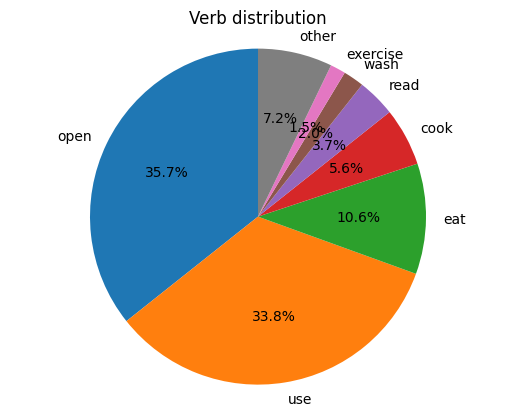

In [85]:
items = sorted(
    key_occ_new.items(),
    key=lambda x: x[1]["occ"],
    reverse=True
)

TOP_K = 7

labels = [k for k, _ in items[:TOP_K]]
sizes = [v["occ"] for _, v in items[:TOP_K]]

other_sum = sum(v["occ"] for _, v in items[TOP_K:])
labels.append("other")
sizes.append(other_sum)

plt.figure()
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Verb distribution")
plt.axis("equal")
plt.show()


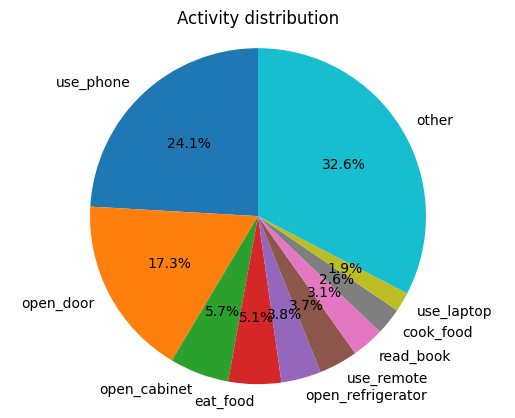

In [92]:
items = sorted(
    value_counts_act.items(),
    key=lambda x: x[1],
    reverse=True
)

TOP_K = 9

labels = [k for k, _ in items[:TOP_K]]
sizes = [v for _, v in items[:TOP_K]]

other_sum = sum(v for _, v in items[TOP_K:])
labels.append("other")
sizes.append(other_sum)

plt.figure()
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Activity distribution")
plt.axis("equal")
plt.show()
